# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [7]:
from tqdm.notebook import tqdm


In [8]:
data =r"C:\Users\nayna\pd project\trainig\train"
os.listdir(data)

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry_(including_sour)___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_Yellow_Leaf__Curl_Virus']

In [9]:
unique_plants = []
cl = os.listdir(r"C:\Users\nayna\pd project\trainig\train")
for i in cl:
    x = i.split('_')
    if x[0] not in unique_plants:
        unique_plants.append(x[0])
print("Number of Unique Plants: ",len(unique_plants))
print("Unique Plants: ",unique_plants)

Number of Unique Plants:  9
Unique Plants:  ['Apple', 'Cherry', 'Corn', 'Grape', 'Peach', 'Pepper', 'Potato', 'Strawberry', 'Tomato']


In [10]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Force resize all images
    transforms.ToTensor(),
])


In [11]:
dataset = ImageFolder(r"C:\Users\nayna\pd project\trainig\train",transform=transform)
test_ds = ImageFolder(r"C:\Users\nayna\pd project\trainig\test", transform=transform)
val_ds = ImageFolder(r"C:\Users\nayna\pd project\trainig\val", transform=transform)

In [12]:
print("Number of training images: ",len(dataset))
print("Number of testing images: ",len(test_ds))
print("number of val images:", len(val_ds))

Number of training images:  29827
Number of testing images:  1220
number of val images: 8000


In [13]:
num_classes = dataset.classes
print("Number of classes: ",len(num_classes))
print(num_classes)

Number of classes:  33
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_Yellow_Leaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


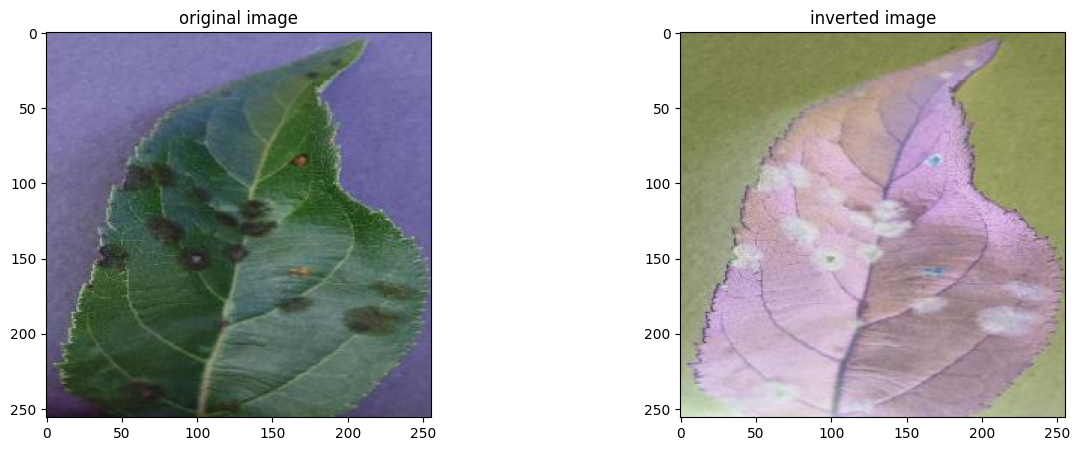

In [84]:
image, label  = dataset[0]
fig,(ax1,ax2) = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
ax1.imshow(image.permute(1,2,0))
ax1.set_title("original image")
ax2.imshow(1-image.permute(1,2,0))
ax2.set_title("inverted image")
plt.show()

In [14]:
epochs = 30
random_seed = 42
torch.manual_seed(random_seed)


In [15]:
batch_size = 64

train_loader = DataLoader(dataset,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

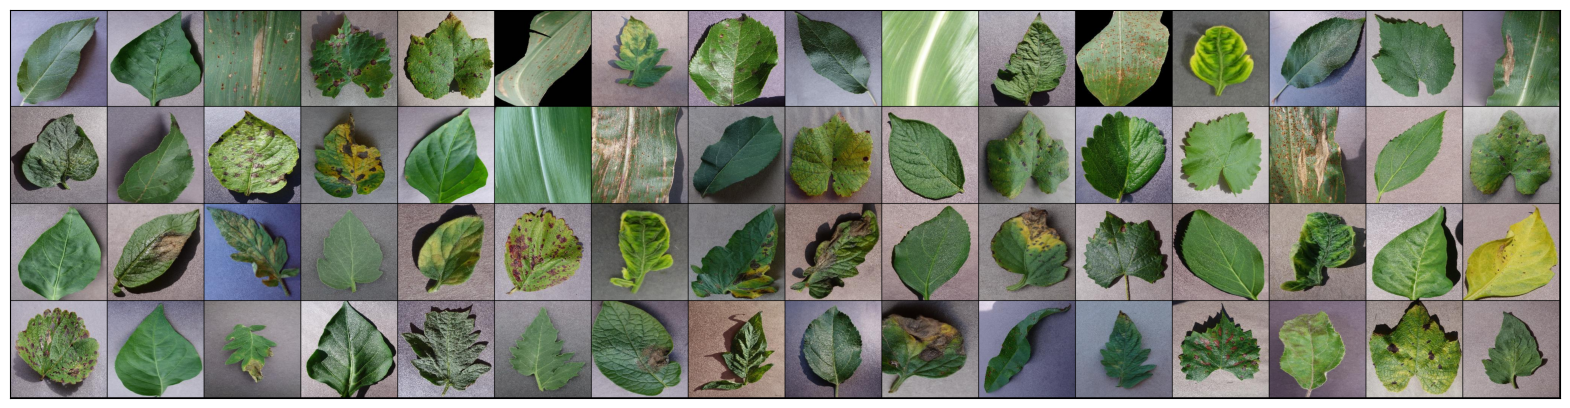

In [87]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [26]:
# Accuracy helper
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Base training/validation structure
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)  # Add device transfer
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc}  # Return as dict

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

In [27]:
import torch.nn as nn

class MyNN(ImageClassificationBase):
    def __init__(self, ip_features=3, num_classes = 33):
        super().__init__()
    
        self.features = nn.Sequential(
            nn.Conv2d(ip_features, 16, kernel_size=3, padding=1),  # (16, 256, 256)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (16, 128, 128)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),           # (32, 128, 128)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),           # (64, 64, 64)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),          # (128, 32, 32)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (128, 16, 16)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),         # (256, 16, 16)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # (256, 8, 8)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512,num_classes)  # Make num_classes dynamic
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [28]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to device
model = MyNN(ip_features=3 , num_classes = 33).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [29]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        train_accs = []
        
        for batch in tqdm(train_loader):
            result = model.training_step(batch)  # Returns dict
            loss = result['train_loss']
            acc = result['train_acc']
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_losses.append(loss)
            train_accs.append(acc)
        
        # Validation
        val_result = evaluate(model, val_loader)
        val_result['train_loss'] = torch.stack(train_losses).mean().item()
        val_result['train_acc'] = torch.stack(train_accs).mean().item()
        
        model.epoch_end(epoch, val_result)
        history.append(val_result)
    
    return history

In [22]:
evaluate(model,val_loader)

{'val_loss': 3.4971792697906494, 'val_acc': 0.029500000178813934}

In [30]:
history = fit(30, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.6149, val_loss: 0.9250, val_acc: 0.7164


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8686, val_loss: 1.2128, val_acc: 0.6672


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6581, val_loss: 0.3439, val_acc: 0.8863


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5193, val_loss: 0.3217, val_acc: 0.8969


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.4275, val_loss: 0.2340, val_acc: 0.9295


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.3408, val_loss: 0.2072, val_acc: 0.9395


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2974, val_loss: 0.2052, val_acc: 0.9390


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2505, val_loss: 0.2925, val_acc: 0.9234


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.2659, val_loss: 0.5343, val_acc: 0.8690


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1990, val_loss: 0.1077, val_acc: 0.9686


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1937, val_loss: 0.4033, val_acc: 0.8923


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.1924, val_loss: 0.0973, val_acc: 0.9745


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1707, val_loss: 0.0866, val_acc: 0.9776


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1498, val_loss: 0.1132, val_acc: 0.9695


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.1226, val_loss: 0.0960, val_acc: 0.9754


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.1486, val_loss: 1.4980, val_acc: 0.7801


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.1374, val_loss: 0.2543, val_acc: 0.9366


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.1282, val_loss: 1.0256, val_acc: 0.8980


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.1511, val_loss: 1.6454, val_acc: 0.7193


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.1662, val_loss: 0.1591, val_acc: 0.9650


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.0946, val_loss: 0.0935, val_acc: 0.9783


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.0939, val_loss: 0.7744, val_acc: 0.8763


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.1650, val_loss: 0.0878, val_acc: 0.9796


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0893, val_loss: 0.0614, val_acc: 0.9869


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.0874, val_loss: 0.1136, val_acc: 0.9780


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.0855, val_loss: 0.1368, val_acc: 0.9721


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0886, val_loss: 0.3644, val_acc: 0.9364


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0992, val_loss: 0.1171, val_acc: 0.9728


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0814, val_loss: 0.2489, val_acc: 0.9525


  0%|          | 0/467 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0880, val_loss: 0.1824, val_acc: 0.9655


In [36]:
import torch.nn.functional as F

def predict_image(img, model, device, dataset):
    model.eval()
    xb = img.unsqueeze(0).to(device)  # [1, C, H, W]
    with torch.no_grad():
        yb = model(xb)
        probs = F.softmax(yb, dim=1)   # Convert logits to probabilities
        confidence, preds = torch.max(probs, dim=1)
    
    predicted_class = dataset.classes[preds.item()]
    confidence_score = confidence.item() * 100  # Convert to %
    
    return predicted_class, confidence_score



Label: Apple___Apple_scab , Predicted: Apple___Apple_scab


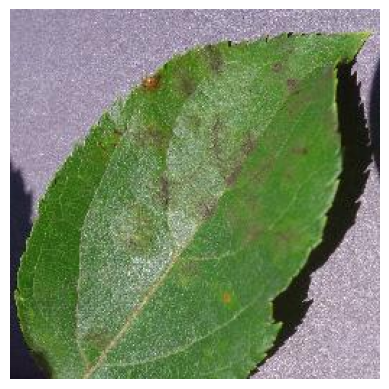

In [104]:
# Example: predicting on an image from the validation set
img, label = val_ds[25]  # Assuming val_ds is your validation Dataset (not DataLoader)

plt.imshow(img.permute(1, 2, 0))  # Convert [C,H,W] to [H,W,C] for display
plt.axis('off')
predicted = predict_image(img, model, device, val_ds)
print('Label:', val_ds.classes[label], ', Predicted:', predicted)


Label: Tomato___Septoria_leaf_spot
Predicted: Tomato___Septoria_leaf_spot
Confidence: 100.00%


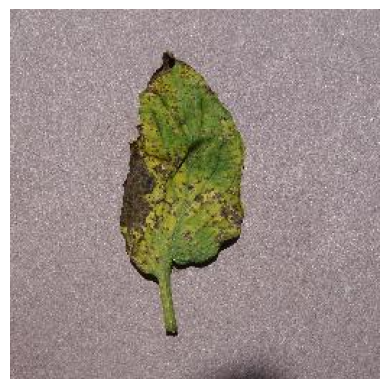

In [38]:
# Get the image and label from the dataset
img, label = test_ds[1000]

# Convert tensor to PIL image for display (no permute needed)
from torchvision.transforms.functional import to_pil_image
img_pil = to_pil_image(img)

# Display the image
plt.imshow(img_pil)
plt.axis('off')

# Get prediction and confidence
predicted_label, confidence_score = predict_image(img, model, device, test_ds)

# Print the results
print('Label:', test_ds.classes[label])
print('Predicted:', predicted_label)
print(f"Confidence: {confidence_score:.2f}%")



In [40]:
# Save the trained model
torch.save(model.state_dict(), 'plant_disease_model.pth')


In [110]:
# Save
torch.save(model.state_dict(), 'plant_disease_cnn.pth')

# Load
model = MyNN(ip_features=3)
model.load_state_dict(torch.load('plant_disease_cnn.pth'))
model.eval()


MyNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st